<a href="https://colab.research.google.com/github/vaneesa-writes/micro_project/blob/main/nuceli_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
#!kaggle competitions download -c data-science-bowl-2018

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import os

In [ ]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
#os.mkdir('test')

In [ ]:
# import shutil
# lis = os.listdir()
# for ele in lis:
#   if(len(ele)>40):
#     source = ele+'/'
#     destination = '/content/test+/'
    
#     shutil.move(source , destination)

In [ ]:
# !unzip /content/stage1_train.zip

In [ ]:
# os.mkdir('train')

In [ ]:
# lis = os.listdir('train/1815cf307859b3e13669041d181aa3b3dbbac1a95aef4c42164b223110c09168/masks')
# lis

In [ ]:
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]



In [ ]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask

In [ ]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    #print(path + '/images/' + id_ + '.png')
    try:
      img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
      sizes_test.append([img.shape[0], img.shape[1]])
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_test[n] = img
    except:
      print('fail')

 45%|████▍     | 29/65 [00:00<00:00, 42.36it/s]

fail


100%|██████████| 65/65 [00:01<00:00, 32.92it/s]


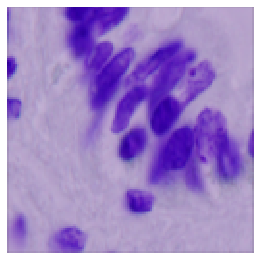

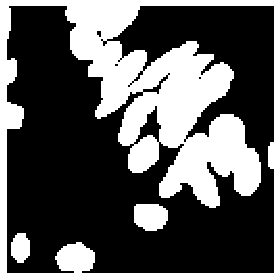

In [ ]:
image_x = random.randint(0, len(train_ids))
#print(X_train[image_x].shape)
imshow(X_train[image_x])
plt.axis('off')
plt.show()
#print(Y_train[image_x].shape)
#print(np.squeeze(Y_train[image_x]).shape)
plt.axis('off')
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)


Epoch 1/25
38/38 [==============================] - 16s 82ms/step - loss: 0.4865 - accuracy: 0.7985 - val_loss: 0.3611 - val_accuracy: 0.8293
Epoch 2/25
38/38 [==============================] - 1s 39ms/step - loss: 0.2425 - accuracy: 0.8849 - val_loss: 0.2362 - val_accuracy: 0.9135
Epoch 3/25
38/38 [==============================] - 1s 38ms/step - loss: 0.1443 - accuracy: 0.9451 - val_loss: 0.1501 - val_accuracy: 0.9375
Epoch 4/25
38/38 [==============================] - 1s 40ms/step - loss: 0.1208 - accuracy: 0.9539 - val_loss: 0.1231 - val_accuracy: 0.9525
Epoch 5/25
38/38 [==============================] - 1s 39ms/step - loss: 0.1138 - accuracy: 0.9565 - val_loss: 0.1206 - val_accuracy: 0.9520
Epoch 6/25
38/38 [==============================] - 1s 39ms/step - loss: 0.1074 - accuracy: 0.9596 - val_loss: 0.1222 - val_accuracy: 0.9518
Epoch 7/25
38/38 [==============================] - 1s 40ms/step - loss: 0.1031 - accuracy: 0.9614 - val_loss: 0.1080 - val_accuracy: 0.9577
Epoch 8/25
3

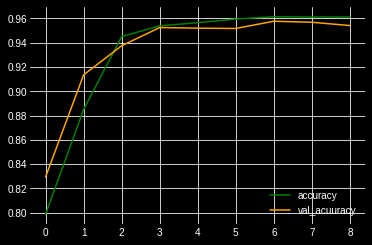

In [ ]:
plt.style.use('_classic_test_patch')
plt.plot(results.history['accuracy'],c='green',label='accuracy')
plt.plot(results.history['val_accuracy'],c='orange',label='val_acuuracy')
plt.legend()
plt.show()

In [ ]:

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



3/3 [==============================] - 0s 13ms/step


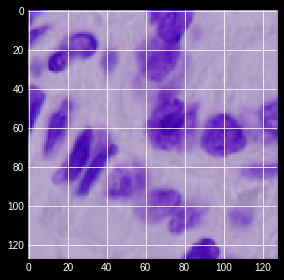

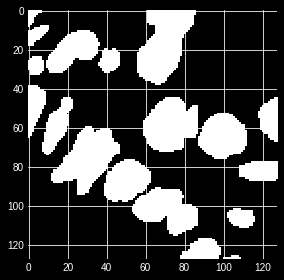

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


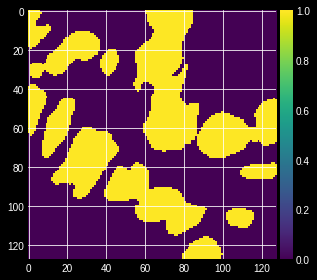

In [ ]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


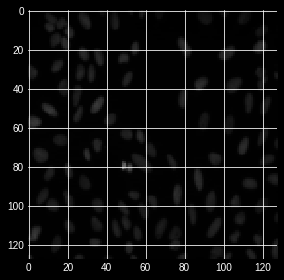

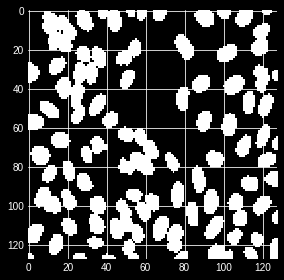

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


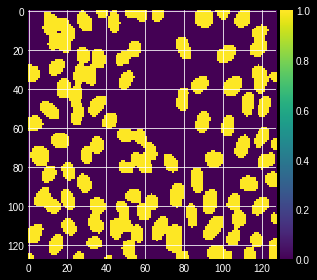

In [ ]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()